# **CNN**

**Import Necessary Libraries and Data**

In [ ]:
# To store and process in a dataframe
import pandas as pd
# Advanced ploting
import seaborn as sns
# For ploting graphs
import matplotlib.pyplot as plt
# For numerical analysis
import numpy as np
from numpy import argmax, array_equal
# Layers
from keras.layers import Dense, Input, Conv2D, LSTM, MaxPool2D, UpSampling2D, Dropout, Flatten, MaxPooling2D
# Train test split
from sklearn.model_selection import train_test_split
# Stop the training when there is no improvement in the loss for three consecutive epochs
from keras.callbacks import EarlyStopping
# Model performance metrics
from sklearn.metrics import classification_report
# Utility functions
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
# Sequential model
from tensorflow.keras.models import Sequential, Model
from imgaug import augmenters
from random import randint
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.layers import BatchNormalization


In [ ]:
# Remove any file and Delete .kaggle directory
!rm -r ~/.kaggle

rm: cannot remove '/root/.kaggle': No such file or directory


In [ ]:
# Install Kaggle
!pip install -q kaggle

In [ ]:
# To upload kaggle.json file
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"kaveeshahiruni","key":"e55502de6f913d6e141e149a78974607"}'}

In [ ]:
# To save this file into a directory
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/

# To change the permission of the file
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Download the food MNIST dataset from Kaggle
!kaggle datasets download -d utkarshsaxenadn/fast-food-classification-dataset

 98% 802M/821M [00:15<00:00, 52.5MB/s]
100% 821M/821M [00:15<00:00, 55.8MB/s]


In [ ]:
# Extract the files in the zip file
!unzip -n 'fast-food-classification-dataset.zip'

Streaming output truncated to the last 5000 lines.
  inflating: Fast Food Classification V2/Train/Taquito/Taquito-Train (1).jpeg  
  inflating: Fast Food Classification V2/Train/Taquito/Taquito-Train (10).jpeg  
  inflating: Fast Food Classification V2/Train/Taquito/Taquito-Train (100).jpeg  
  inflating: Fast Food Classification V2/Train/Taquito/Taquito-Train (1000).jpeg  
  inflating: Fast Food Classification V2/Train/Taquito/Taquito-Train (1001).jpeg  
  inflating: Fast Food Classification V2/Train/Taquito/Taquito-Train (1002).jpeg  
  inflating: Fast Food Classification V2/Train/Taquito/Taquito-Train (1003).jpeg  
  inflating: Fast Food Classification V2/Train/Taquito/Taquito-Train (1004).jpeg  
  inflating: Fast Food Classification V2/Train/Taquito/Taquito-Train (1005).jpeg  
  inflating: Fast Food Classification V2/Train/Taquito/Taquito-Train (1006).jpeg  
  inflating: Fast Food Classification V2/Train/Taquito/Taquito-Train (1007).jpeg  
  inflating: Fast Food Classification V2/T

In [ ]:
# Declare the folder path for the images
ROOT_PATH = '/content/Fast Food Classification V2'
training_path = f'{ROOT_PATH}/Train'
validation_path = f'{ROOT_PATH}/Test'
evaluation_path = f'{ROOT_PATH}/Valid'

In [ ]:
from PIL import Image
import numpy as np

# Function to load and convert images to RGBA format
def load_and_convert_to_rgba(image_path):
    image = Image.open(image_path)
    if image.mode != "RGBA":
        image = image.convert("RGBA")
    return np.array(image)

# Example usage in the data generator:
def generator_with_rgba_conversion(generator):
    for batch_x, batch_y in generator:
        batch_x_rgba = [load_and_convert_to_rgba(image_path) for image_path in generator.filenames]
        yield (np.array(batch_x_rgba), batch_y)


**Preprocessing and** **Augmentation**

In [ ]:
# Define image dimensions and batch size
img_width, img_height = 128, 128
batch_size = 32

In [ ]:
# Data Augmentation
datagen = ImageDataGenerator(
    rescale=1.0/255.0,  # Normalize pixel values to [0, 1]
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [ ]:
# Create data generators for training directories and apply data augmentation
train_datagen = datagen.flow_from_directory(
    training_path,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)
# Modify the existing data generators to use the generator_with_rgba_conversion
train_generator_with_rgba = generator_with_rgba_conversion(train_datagen)

Found 15000 images belonging to 10 classes.


In [ ]:
# Load images from validation directories and apply data augmentation
validation_datagen = datagen.flow_from_directory(
    validation_path,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)
validation_generator_with_rgba = generator_with_rgba_conversion(validation_datagen)


Found 1500 images belonging to 10 classes.


In [ ]:
# Load images from evaluation directories and apply data augmentation
evaluation_datagen = datagen.flow_from_directory(
    evaluation_path,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

evaluation_generator_with_rgba = generator_with_rgba_conversion(evaluation_datagen)

Found 3500 images belonging to 10 classes.


In [ ]:
# Create a sequential model
model = Sequential()

# Add convolutional layers
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, 3)))
model.add(MaxPool2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPool2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPool2D((2, 2)))

# Flatten the output and add dense layers
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))  # Adjust the number of output classes

In [ ]:
# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'])


In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 63, 63, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 14, 14, 128)      

In [ ]:
# Set up early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


In [ ]:
# Learning Rate
def lr_scheduler(epoch):
    initial_lr = 0.001
    if epoch < 10:
        return initial_lr
    else:
        return initial_lr * tf.math.exp(0.1 * (10 - epoch))

lr_schedule = LearningRateScheduler(lr_scheduler)

**Train the model**

In [ ]:
# Train the model with early stopping and learning rate
history = model.fit(
    train_datagen,
    epochs=20,  # Adjust the number of epochs as needed
    validation_data=validation_datagen,
    callbacks=[lr_schedule, early_stopping]
)

Epoch 1/20
245/469 [==============>...............] - ETA: 40s - loss: 2.2444 - accuracy: 0.1690

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


469/469 [==============================] - 96s 195ms/step - loss: 2.1808 - accuracy: 0.2054 - val_loss: 1.9968 - val_accuracy: 0.2707 - lr: 0.0010
Epoch 2/20
469/469 [==============================] - 89s 189ms/step - loss: 1.9989 - accuracy: 0.2949 - val_loss: 1.8037 - val_accuracy: 0.3567 - lr: 0.0010
Epoch 3/20
469/469 [==============================] - 90s 191ms/step - loss: 1.8569 - accuracy: 0.3578 - val_loss: 1.6807 - val_accuracy: 0.4100 - lr: 0.0010
Epoch 4/20
469/469 [==============================] - 88s 187ms/step - loss: 1.7605 - accuracy: 0.3994 - val_loss: 1.7656 - val_accuracy: 0.4047 - lr: 0.0010
Epoch 5/20
469/469 [==============================] - 91s 193ms/step - loss: 1.6631 - accuracy: 0.4352 - val_loss: 1.5086 - val_accuracy: 0.4780 - lr: 0.0010
Epoch 6/20
469/469 [==============================] - 89s 189ms/step - loss: 1.6077 - accuracy: 0.4554 - val_loss: 1.5173 - val_accuracy: 0.4740 - lr: 0.0010
Epoch 7/20
469/469 [==============================] - 88s 187ms

**Evaluate the model**

In [ ]:
#Test the model
evaluation_results = model.evaluate(evaluation_datagen)
print("Evaluation loss:", evaluation_results[0])
print("Evaluation accuracy:", evaluation_results[1])

110/110 [==============================] - 18s 164ms/step - loss: 1.2207 - accuracy: 0.6046
Evaluation loss: 1.2207406759262085
Evaluation accuracy: 0.6045714020729065


In [ ]:
predictions = model.predict(evaluation_datagen)

110/110 [==============================] - 17s 150ms/step


**Visulaization of the predictions**

1/1 [==============================] - 0s 24ms/step


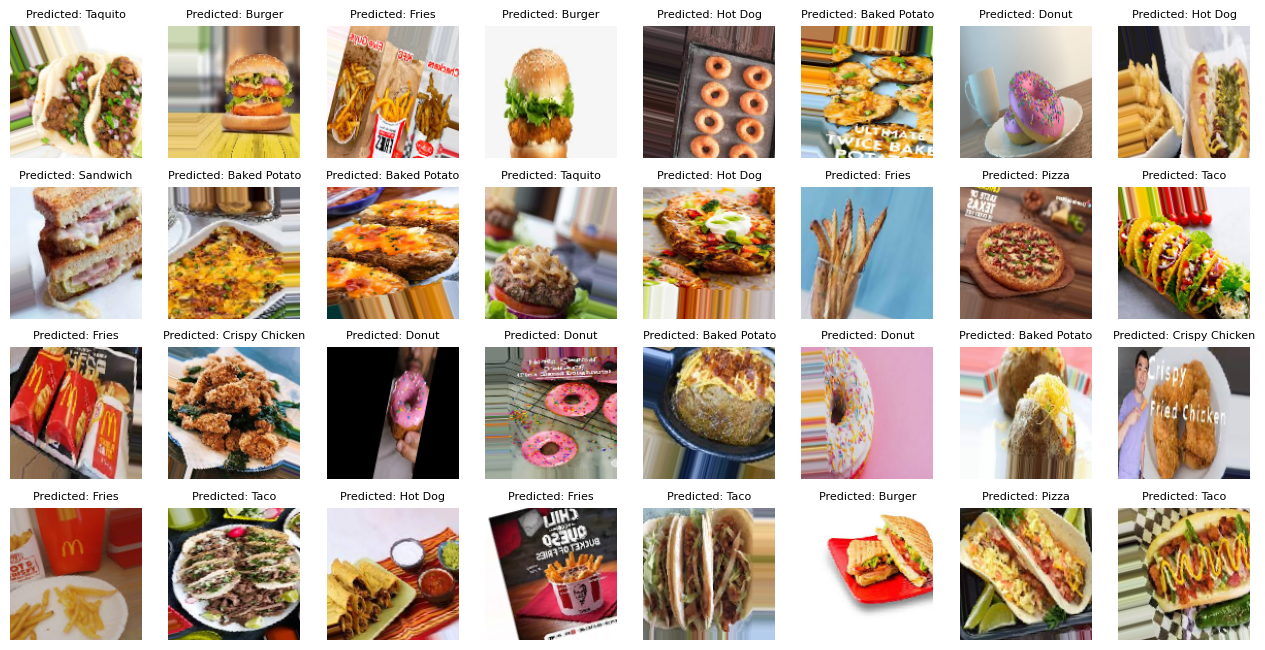

In [ ]:
# Get the class labels
class_labels = list(train_datagen.class_indices.keys())

# Get a batch of images and their true labels (if needed)
image_batch, true_labels_batch = next(evaluation_datagen)

# Make predictions on the batch of images
predicted_labels_batch = model.predict(image_batch)

# Display the images along with their predicted labels
plt.figure(figsize=(16, 8))
for i in range(len(image_batch)):
    plt.subplot(4, 8, i + 1)
    plt.imshow(image_batch[i])

    # Get the predicted label (index of the highest probability)
    predicted_label_index = np.argmax(predicted_labels_batch[i])

    # Map the predicted label index to the class label
    predicted_label = class_labels[predicted_label_index]

   # Display the predicted label with smaller text size
    plt.title(f'Predicted: {predicted_label}', fontsize=8)

    # Remove axis ticks and labels for a cleaner display
    plt.axis('off')

plt.show()

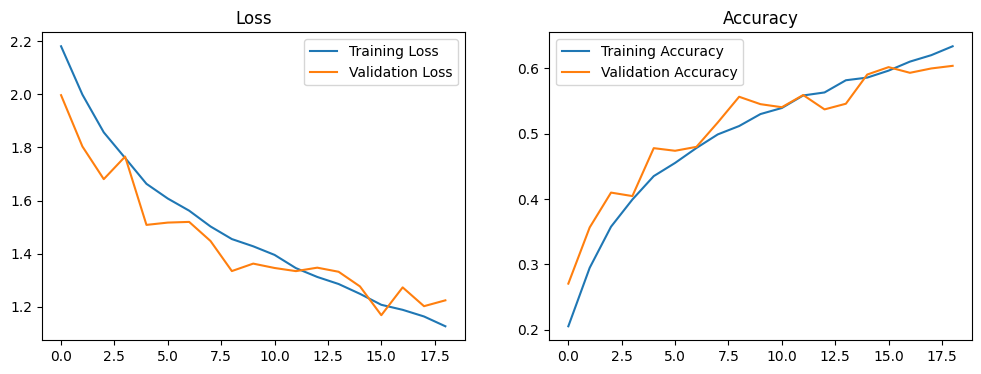

In [ ]:
# Assuming you have 'history' from model training
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.show()

110/110 [==============================] - 17s 151ms/step


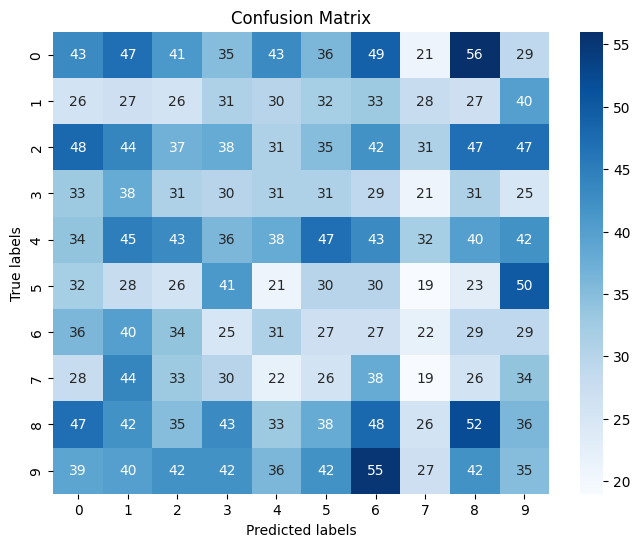

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Make predictions on the evaluation dataset
y_pred = model.predict(evaluation_datagen)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get true labels
y_true = evaluation_datagen.classes

# Create confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues', xticklabels=True, yticklabels=True)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

**ROC Curve and AUC:** Visualize the Receiver Operating Characteristic (ROC) curve and calculate the Area Under the Curve (AUC).
This is a classification problem that has 10 classe and the ROC analysis for each class is done individually (i.e., one-vs-all or one-vs-rest ROC curves).

110/110 [==============================] - 18s 160ms/step


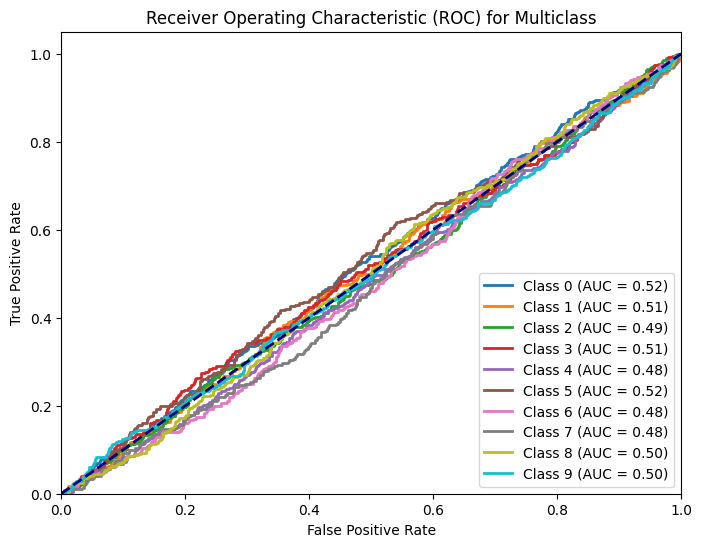

In [ ]:
from sklearn.metrics import roc_curve, auc

# Assuming multiclass classification
n_classes = len(evaluation_datagen.class_indices)

# Initialize empty lists for fpr, tpr, and auc for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

# Generate predictions
predictions = model.predict(evaluation_datagen)

# Get true labels
true_labels = evaluation_datagen.classes

# Compute ROC curve and ROC area for each class
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(true_labels, predictions[:, i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for each class
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) for Multiclass')
plt.legend(loc='lower right')
plt.show()


# **Visualizations of the Dataset**

**Class Distribution Visualization** : Visualize the distribution of classes in your dataset using a bar chart. This helps to understand if the dataset is balanced or skewed towards certain classes.

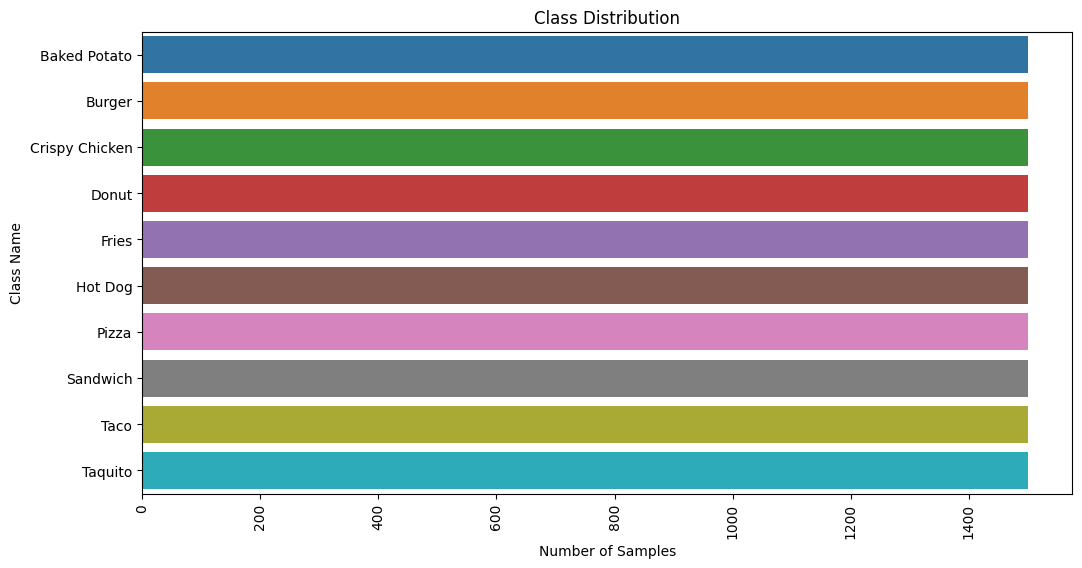

In [ ]:
import os

# Get class names from the subdirectories in the training directory
class_names = sorted(os.listdir(training_path))

# Count the number of samples in each class
class_counts = [len(os.listdir(os.path.join(training_path, class_name))) for class_name in class_names]

# Plot class distribution
plt.figure(figsize=(12, 6))
sns.barplot(x=class_counts, y=class_names)
plt.title('Class Distribution')
plt.xlabel('Number of Samples')
plt.ylabel('Class Name')
plt.xticks(rotation=90)
plt.show()



**Data Distribution Across Train, Validation, and Test Sets:**
Visualize the distribution of data across the training, validation, and test sets to ensure that they are balanced.

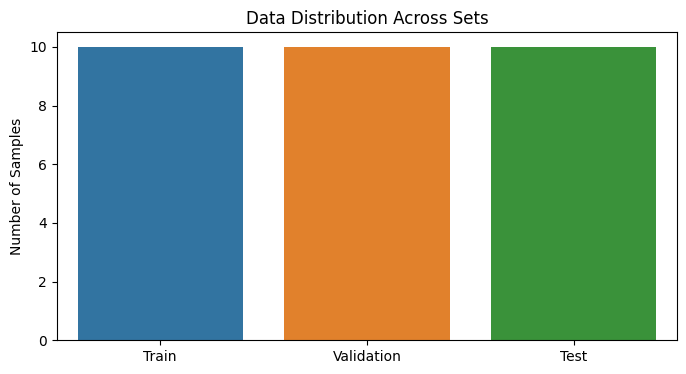

In [ ]:
# Get the number of samples in each set
train_count = len(os.listdir(training_path))
validation_count = len(os.listdir(validation_path))
evaluation_count = len(os.listdir(evaluation_path))

# Plot the distribution
plt.figure(figsize=(8, 4))
sns.barplot(x=['Train', 'Validation', 'Test'], y=[train_count, validation_count, evaluation_count])
plt.title('Data Distribution Across Sets')
plt.ylabel('Number of Samples')
plt.show()

**Random Sample from a class**

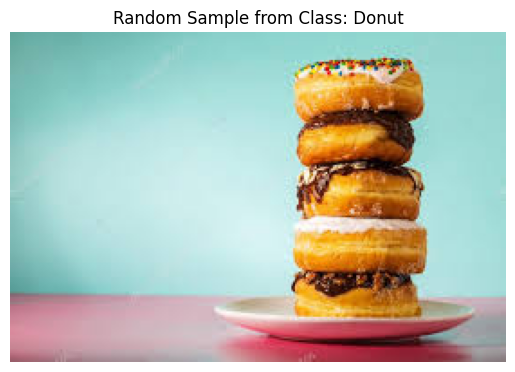

In [ ]:
import random
from PIL import Image

# Choose a random class
random_class = random.choice(class_names)

# Get a list of image file paths for that class
class_path = os.path.join(training_path, random_class)
image_files = os.listdir(class_path)

# Choose a random image from the class
random_image = random.choice(image_files)

# Load and display the random image
image_path = os.path.join(class_path, random_image)
image = Image.open(image_path)
plt.imshow(image)
plt.title(f'Random Sample from Class: {random_class}')
plt.axis('off')
plt.show()

**Image Size Distribution:** Visualize the distribution of image sizes (width and height) in your dataset. This can help you determine if all images have consistent sizes or if there is significant variation.

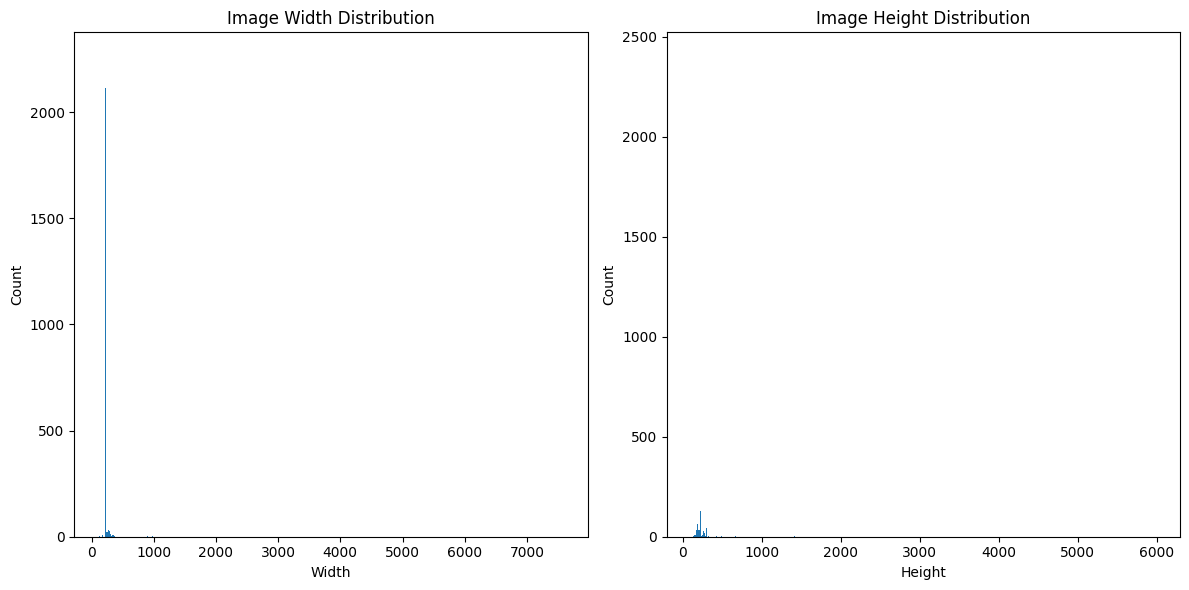

In [ ]:
from collections import defaultdict

# Create dictionaries to store width and height counts
width_counts = defaultdict(int)
height_counts = defaultdict(int)

# Iterate through the dataset to count image sizes
for class_name in class_names:
    class_path = os.path.join(training_path, class_name)
    image_files = os.listdir(class_path)
    for image_file in image_files:
        image_path = os.path.join(class_path, image_file)
        image = Image.open(image_path)
        width, height = image.size
        width_counts[width] += 1
        height_counts[height] += 1

# Plot the distributions
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.bar(width_counts.keys(), width_counts.values())
plt.title('Image Width Distribution')
plt.xlabel('Width')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
plt.bar(height_counts.keys(), height_counts.values())
plt.title('Image Height Distribution')
plt.xlabel('Height')
plt.ylabel('Count')

plt.tight_layout()
plt.show()